This notebook plots the fourier spectrum of neuronal activities with their peaks.
There are different smoothing or gap fillings of the data before plotting but mostly the interpolated data is used

In [32]:
import h5py
import numpy as np
import Functions.Binning as Bin
import copy
import importlib
import matplotlib.pyplot as plt
import Functions.AllFunctions as AllF
import Functions.Make_pandaBinsDataset as MPB
import pandas as pd
from scipy.signal import correlate
from scipy.optimize import curve_fit
import math
import Functions.Autocorr as Aut
import Functions.UnifyWormsFun as UNF
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from numpy.polynomial.polynomial import Polynomial

In [33]:
h5 = h5py.File('MegaData7_7worms_V5.h5', 'r')

In [34]:
L= h5['data_sets_info/lowercam_length']
n_title = [s.decode('utf-8') for s in list(h5['data_sets_info/neuron_names'])]
MegaData0 = np.copy(h5['data/dataraw'])
MegaData0[np.isnan(MegaData0)]=0
MegaData =copy.deepcopy(MegaData0)

smooth=True
gapfilled = True
numW=7

In [35]:
for i in range(55):
    if i >12 and not (i in [27,28,39,40]):
        MegaData[5,:243,i] = 0
        MegaData0[5,:243,i] = 0

for i in range(55):
    MegaData[6,L[6]:,i] = 0
    MegaData0[6,L[6]:,i] = 0

In [36]:
sm = [2,2,2,3,4,3,3]
g=[5,5,5,7,10,7,7]
if smooth:
    for d in range(7):
        for i in range(55):
            if not (i in [10,11,12]):
                MegaData[d,:L[d],i] = Bin.smooth_vec_long(MegaData0[d,:L[d],i],sm[d],g[d])

MegaData_filled =copy.deepcopy(MegaData0)
importlib.reload(AllF)
if gapfilled:
    for d in range(7):
        for i in range(55):
            if not (i in [10,11,12]):
                MegaData_filled[d,:L[d],i] = AllF.fill_in_gaps(MegaData0[d,:L[d],i],g[d])

MegaData_fs =copy.deepcopy(MegaData0)
if smooth and gapfilled:
    for d in range(7):
        for i in range(55):
            if not (i in [10,11,12]):
                MegaData_fs[d,:L[d],i] = Bin.smooth_vec_long(MegaData_filled[d,:L[d],i],sm[d],g[d])

MegaData_filled[MegaData_filled==0] = np.nan

MegaData_interp = copy.deepcopy(MegaData_filled)
for d in range(numW):
    for n in range(55):
        if not (n in [10,11,12]):
            time = MegaData0[d,:L[d],12]
            values = MegaData_filled[d,:L[d],n]
            df = pd.DataFrame({'time': time, 'values': values})
            window_size = 3
            df['values2'] = df['values'].interpolate(method='linear')
            smoothed_values1 = savgol_filter(df['values2'], window_length=5, polyorder=1)
            df['smoothed_values1'] = smoothed_values1
            MegaData_interp[d,:L[d],n] = smoothed_values1

MegaData_interp[np.isnan(MegaData_interp)]=0
MegaData_filled[np.isnan(MegaData_filled)]=0

In [37]:
##correct odor labels:
#intervals of IAA and nonanone
IAA_int = np.zeros((numW,4))
NN_int = np.zeros((numW,4))
IAA_int[0,:] = [210,690,1775,2255]
IAA_int[1,:] = [210,690,1775,2255]
IAA_int[2,:] = [210,690,1775,2255]
IAA_int[3,:] = [210,690,1775,2255]
IAA_int[4,:] = [1,500,1575,2055]
NN_int[0,:] = [997,1477,2555,3040]
NN_int[1,:] = [997,1477,2555,3040]
NN_int[2,:] = [997,1477,2555,3040]
NN_int[3,:] = [997,1477,2555,3040]
NN_int[4,:] = [797,1277,2350,2840]
NN_int[5,:] = [957,1437,2520,3000]
IAA_int[5,:] = [177,657,1737,2240]
NN_int[6,:] = [1080,1560,2560,3000]
IAA_int[6,:] = [300,780,1780,2260]


In [38]:
%matplotlib widget

In [39]:
def fourier_andPlot(signal,sampling_interval,titre = "Power Spectrum",ylab='Power',pl=True):
    fs = 1 / sampling_interval# Sampling frequency in Hz 
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=1/fs)  # Frequency bins
    
    # Compute Power Spectrum
    power_spectrum = np.abs(fft_vals)**2  # Magnitude squared
    mask = (fft_freqs >= 0.0049) & (fft_freqs <= 0.1)  # Mask for desired range
    focused_freqs = fft_freqs[mask]
    focused_power = power_spectrum[mask]
    focused_power = focused_power/np.max(focused_power)
    
    peaks, _ = find_peaks(focused_power, distance=10)  # `distance` avoids closely spaced peaks

    # Sort peaks by power and get the top 3
    top_peaks = peaks[np.argsort(focused_power[peaks])[-3:]]
    # Plot the Power Spectrum
    if pl:
        fig = plt.figure(figsize=(10,3))
        ax = fig.add_subplot()
        ax.plot(focused_freqs, focused_power,zorder=1)
        ax.scatter(focused_freqs[top_peaks], focused_power[top_peaks],s=150,marker = '*', color='red', label="Peaks",zorder=2)
        for peak in top_peaks:
            freq = focused_freqs[peak]
            power = focused_power[peak]
            ax.annotate(f"{freq:.3f} Hz", (freq, power), xytext=(5, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'))    
        ax.set_title(titre)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel(ylab)
        plt.grid()
    return focused_power,focused_freqs,top_peaks

### Plot single neurons spectrum

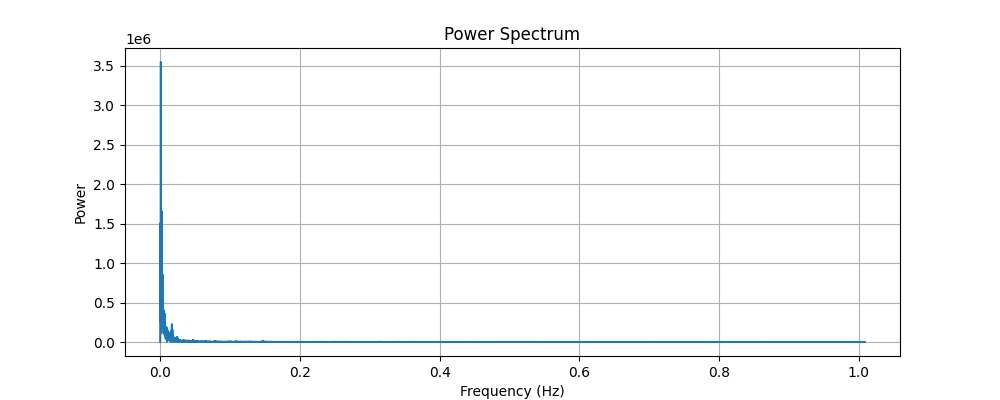

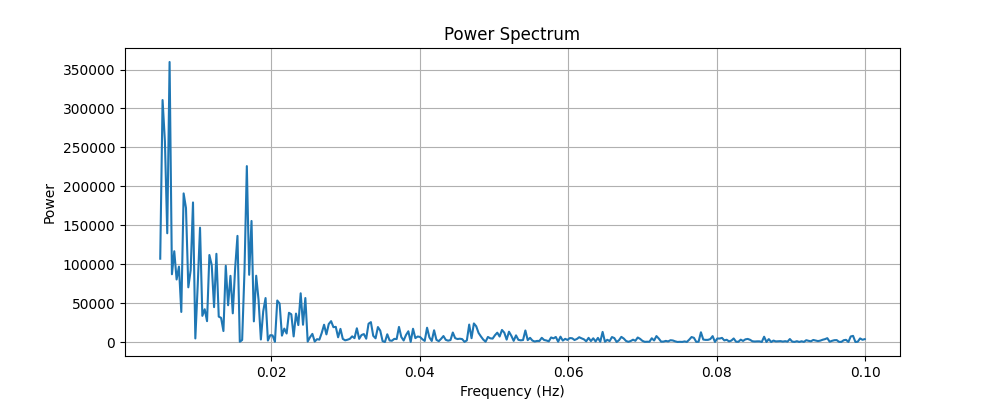

In [40]:
#plot fourie spectrum of worm d0 and neuron n
d0=5
n=5

signal= AllF.compute_vector_z_score(MegaData_filled[d0,:L[d0],n])
sampling_interval = MegaData0[d0,4,12] - MegaData0[d0,3,12]  # Sampling interval in seconds
fs = 1 / sampling_interval# Sampling frequency in Hz 
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal), d=1/fs)  # Frequency bins

# Compute Power Spectrum
power_spectrum = np.abs(fft_vals)**2  # Magnitude squared

# Keep only the positive frequencies
positive_freqs = fft_freqs[fft_freqs >= 0]
positive_power = power_spectrum[fft_freqs >= 0]

mask = (fft_freqs >= 0.0049) & (fft_freqs <= 0.1)  # Mask for desired range
focused_freqs = fft_freqs[mask]
focused_power = power_spectrum[mask]

# Plot the Power Spectrum
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
ax.plot(positive_freqs, positive_power)
ax.set_title("Power Spectrum")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
plt.grid()
plt.show()

# Plot the Power Spectrum
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
ax.plot(focused_freqs, focused_power)
ax.set_title("Power Spectrum")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
plt.grid()
plt.show()
#a,b = fourier_andPlot(signal,sampling_interval)

## Plots in the thesis

In [41]:
#initialize matrices for peaks of fourier expansion for each neuron and each worm
neu_ind = [0,1,2,3,4,5,6,7,8,27,28,39,40]
num_neu = len(neu_ind)
top_peak = np.zeros((numW,num_neu))#
top_peak2 = np.zeros((numW,num_neu))#
top_peak3 = np.zeros((numW,num_neu))#

In [42]:
WormLabel = ['W0','W1','W2','W3','W4','W5','W6']
Neur_lab = ["RIAL","RIAR","RIML","RIMR","RIBL","RIBR",'Sens.',"nrDL","loopL","nrDR","loopR","nrVL","nrVR"]

In [43]:

for d0 in range(numW):
    for n in range(num_neu):
        neu = neu_ind[n]
        signal= AllF.compute_vector_z_score(MegaData_interp[d0,:L[d0],neu])
        sampling_interval = MegaData0[d0,4,12] - MegaData0[d0,3,12]
        a,b,p = fourier_andPlot(signal,sampling_interval,titre = 'neu'+str(neu),ylab='Worm'+str(d0),pl=False)
        if len(p)>0:
            top_peak[d0,n] = p[0]
            top_peak2[d0,n] = b[p[-1]]
            top_peak3[d0,n] = b[np.argmax(a)]

/mnt/DATA/Mahsa/movies/LongRecordings/codes/Cluster/Functions/AllFunctions.py:334: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(vector[np.nonzero(vector)[0]])
/home/mahsa/anaconda3/envs/Targettrack/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_1633295/2290674496.py:11: RuntimeWarning: invalid value encountered in true_divide
  focused_power = focused_power/np.max(focused_power)


### Heat map of peaks of spectrums

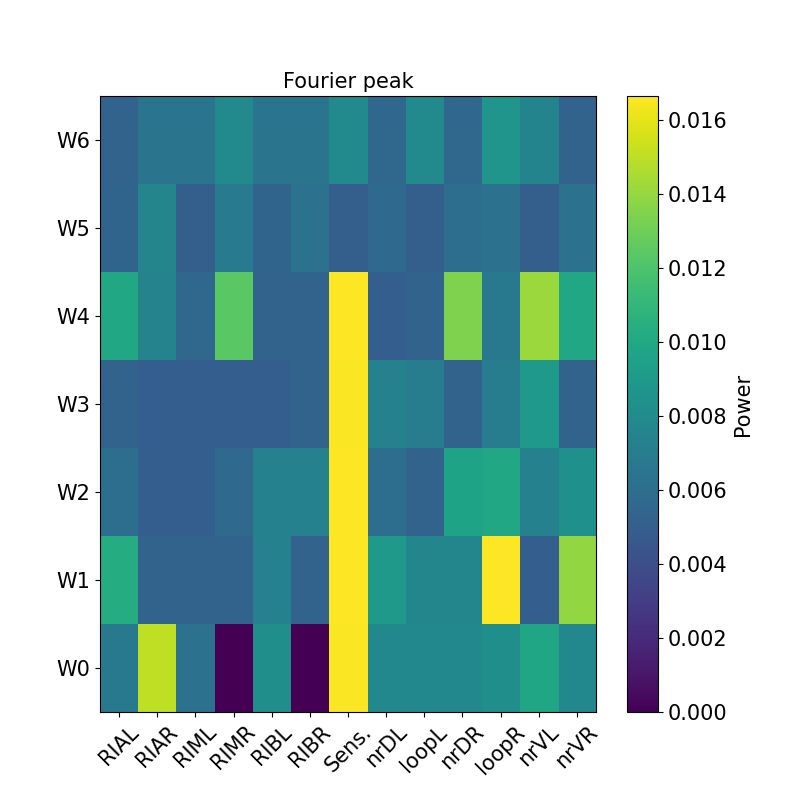

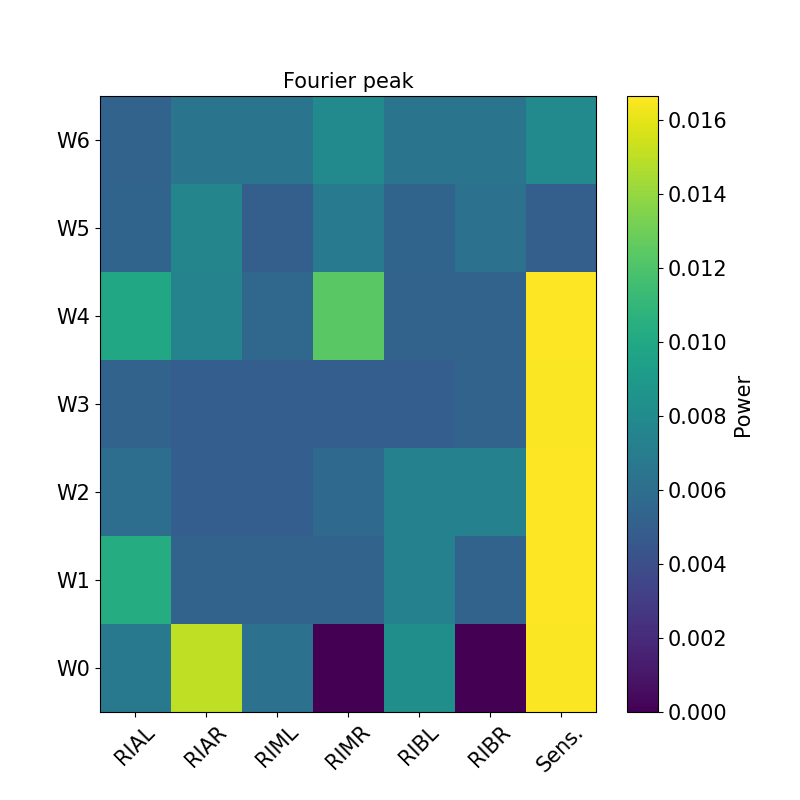

In [44]:
#plot peak of fourier spectrum for all neurons
Aut.plot_parameters_heat(top_peak3,Neur_lab, WormLabel, paramName='Power',fs = 15,titre = 'Fourier peak')
Aut.plot_parameters_heat(top_peak3[:,:numW],Neur_lab[:7], WormLabel, paramName='Power',fs = 15,titre = 'Fourier peak')

### Bar plots of peaks of spectrums

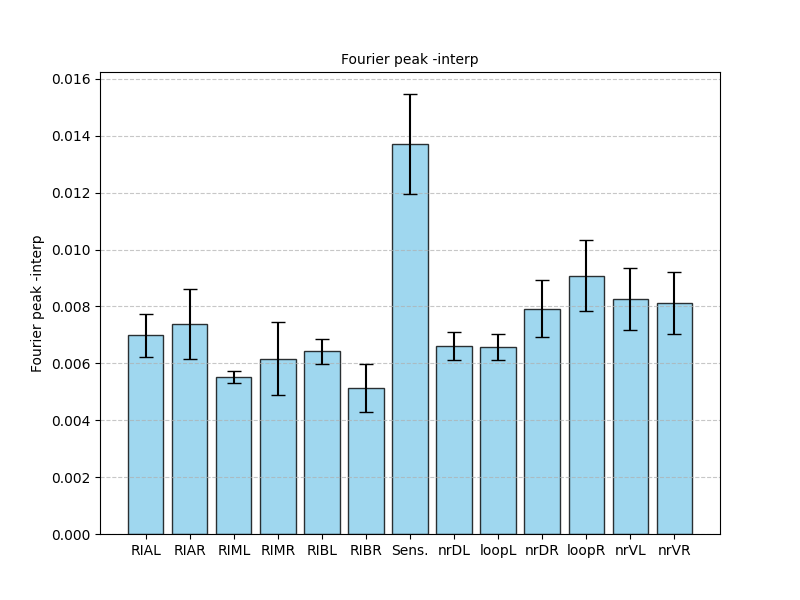

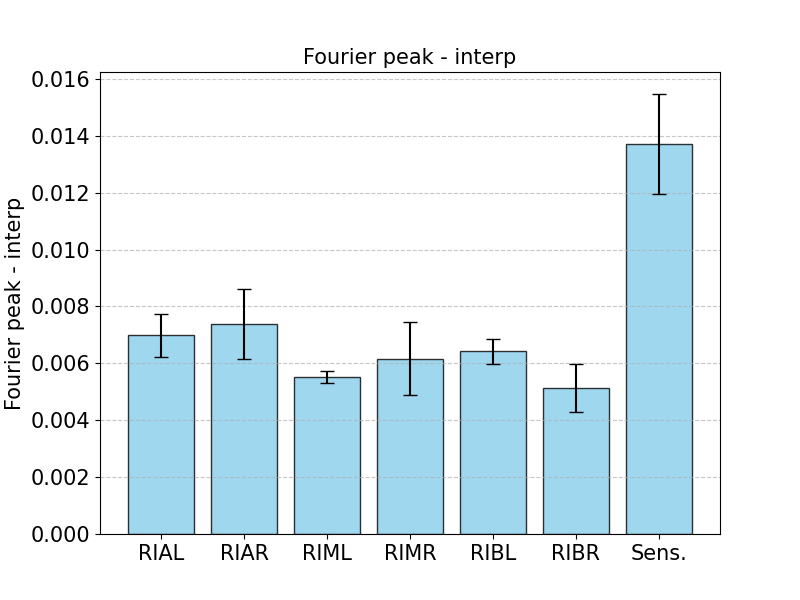

In [45]:
#plot distribution of frequency of fourier peaks for interpolated data
Aut.plot_parameters_bar(top_peak3,Neur_lab, fs = 10, paramName= 'Fourier peak -interp')
Aut.plot_parameters_bar(top_peak3[:,:numW],Neur_lab[:7],fs = 15, paramName= 'Fourier peak - interp')


### plot Fourier spectrum for neuron m for all worms.
Green line denotes the frequency of odor. The first 3 peaks of the spectrum are marked with red stars. If one of the first 3 peaks are close enough to odor frequency, its power is annotated by p in the plot

The closest peak to odor requency has distance:
0.00403664128396653
The closest peak to odor requency has distance:
0.003516641107048784


Text(0.01, 0.5, 'power')

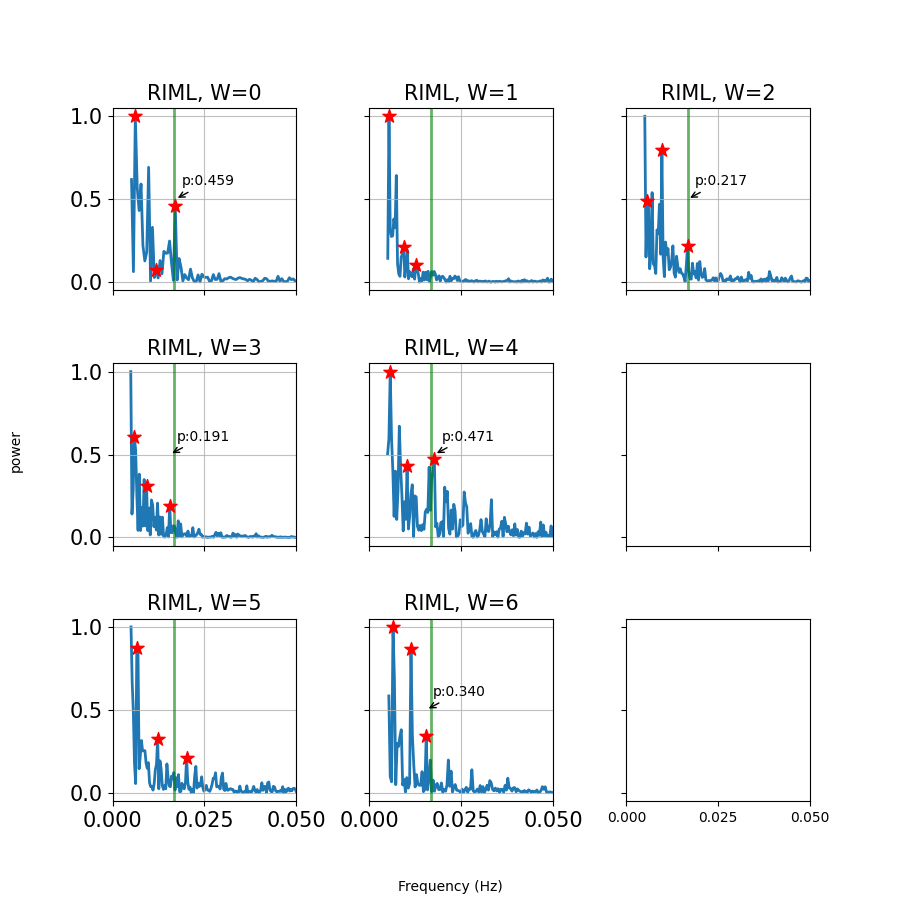

In [46]:

fig, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

Neur_lab = ["RIAL","RIAR","RIML","RIMR","RIBL","RIBR",'Sens.',"nrDL","loopL","nrDR","loopR","nrVL","nrVR"]
m=2
NeuName= Neur_lab[m]
worms=[0,1,2,3,4,5,6]
# Loop over all worms
for i in range(len(worms)):
    if i<5:
        ax = axes[i//3, i%3]  # Access the subplot
    else:
        ax = axes[(i+1)//3, (i+1)%3]
    d= worms[i]
    # Extract normalized neuronal activity for neuron m
    neu = m
    signal= AllF.compute_vector_z_score(MegaData_interp[d,:L[d],neu])
    sampling_interval = MegaData0[d,4,12] - MegaData0[d,3,12]
    a,b,p = fourier_andPlot(signal,sampling_interval,titre = NeuName,ylab='Worm'+str(d),pl=False)
    

    ax.plot(b, a,lw=2,zorder=1)
    ax.axvline(0.016666,color='green',alpha=0.6,lw=2)
    ax.scatter(b[p], a[p],marker = '*', color='red', label="Peaks",zorder=2,s=100)
    
    # Add titles and grid
    ax.set_title(NeuName+f", W={d}", fontsize=15)

    ax.set_xlim(0,0.05)
    ax.grid(alpha=0.8, zorder=0) 
    ax.tick_params(which='both', bottom=True, left=True)
    if len(p)>0:
        odor_peak = p[AllF.closest_index(b[p],0.01666666)]
        if np.abs(b[odor_peak]- 0.016666)<0.0015:
            ax.annotate(f"p:{a[odor_peak]:.3f}", (b[odor_peak],0.5), xytext=(5, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        else:
            print("The closest peak to odor requency has distance:")
            print(np.abs(b[odor_peak]- 0.016666))
    # Remove ticks for better readability
    ax.tick_params(axis='both', which='major', labelsize=15)

# Set shared labels
fig.text(0.5, 0.01, 'Frequency (Hz)', ha='center', fontsize=10)
fig.text(0.01, 0.5, 'power', va='center', rotation='vertical', fontsize=10)

### plot Fourier spectrum for neuron m only during first IAA and Nonanone series.
Green line denotes the frequency of odor. The power of spectrum at odor frequency is marked with red star and the power of the red star is denoted with p.

Text(0.01, 0.5, 'power')

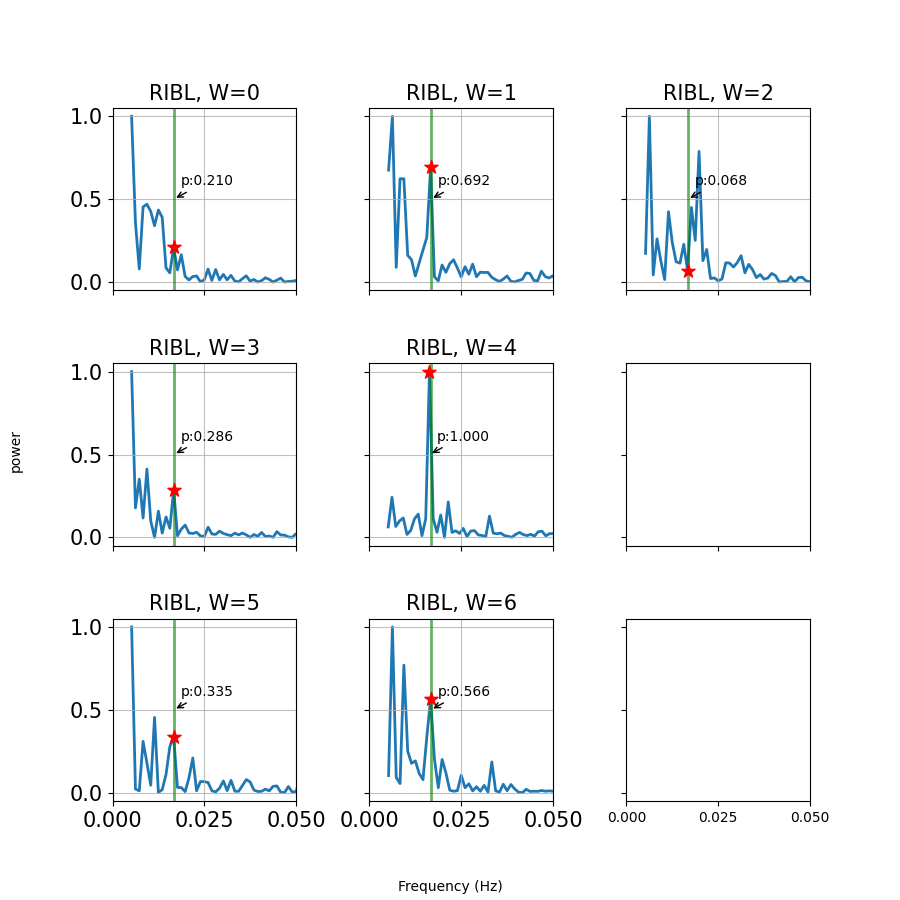

In [47]:

fig, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

Neur_lab = ["RIAL","RIAR","RIML","RIMR","RIBL","RIBR",'Sens.',"nrDL","loopL","nrDR","loopR","nrVL","nrVR"]
m=4
NeuName= Neur_lab[m]
worms=[0,1,2,3,4,5,6]
# Loop over all worms
for i in range(numW):
    if i<5:
        ax = axes[i//3, i%3]  # Access the subplot
    else:
        ax = axes[(i+1)//3, (i+1)%3]
    d= worms[i]
    # Extract the lower camera indices marking start and end of first IAA and 2-nn series
    neu = m
    secI0 = AllF.closest_index(MegaData[d,:,12],IAA_int[d,0])
    secI1 = AllF.closest_index(MegaData[d,:,12],IAA_int[d,1])
    secN0 = AllF.closest_index(MegaData[d,:,12],NN_int[d,0])
    secN1 = AllF.closest_index(MegaData[d,:,12],NN_int[d,1])
    
    # Extract the interpolated neuronal activity a during first IAA and 2-nn
    signal0= AllF.compute_vector_z_score(MegaData_interp[d,:L[d],neu])
    signal = np.concatenate((signal0[secI0:secI1], signal0[secN0:secN1]))

    sampling_interval = MegaData0[d,4,12] - MegaData0[d,3,12]
    a,b,p = fourier_andPlot(signal,sampling_interval,titre = NeuName,ylab='Worm'+str(d),pl=False)
    

    ax.plot(b, a,lw=2,zorder=1)
    ax.axvline(0.016666,color='green',alpha=0.6,lw=2)
    Odorpeak = AllF.closest_index(b,0.016666)
    ax.scatter(b[Odorpeak], a[Odorpeak],marker = '*', color='red', label="Peaks",zorder=2,s=100)

    ax.set_title(NeuName+f", W={d}", fontsize=15)

    ax.set_xlim(0,0.05)
    ax.grid(alpha=0.8, zorder=0) 
    ax.tick_params(which='both', bottom=True, left=True)
    ax.annotate(f"p:{a[Odorpeak]:.3f}", (b[Odorpeak],0.5), xytext=(5, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
    # Remove ticks for better readability
    ax.tick_params(axis='both', which='major', labelsize=15)

# Set shared labels
fig.text(0.5, 0.01, 'Frequency (Hz)', ha='center', fontsize=10)
fig.text(0.01, 0.5, 'power', va='center', rotation='vertical', fontsize=10)

### Plot Fourier spectrum for all neurons (except neurites) for all worms.
Green line denotes the frequency of odor. The first 3 peaks of the spectrum are marked with red stars. If one of the first 3 peaks are close enough to odor frequency, its power is annotated by p in the plot

/tmp/ipykernel_1633295/2290674496.py:11: RuntimeWarning: invalid value encountered in true_divide
  focused_power = focused_power/np.max(focused_power)


Text(0.04, 0.5, 'power')

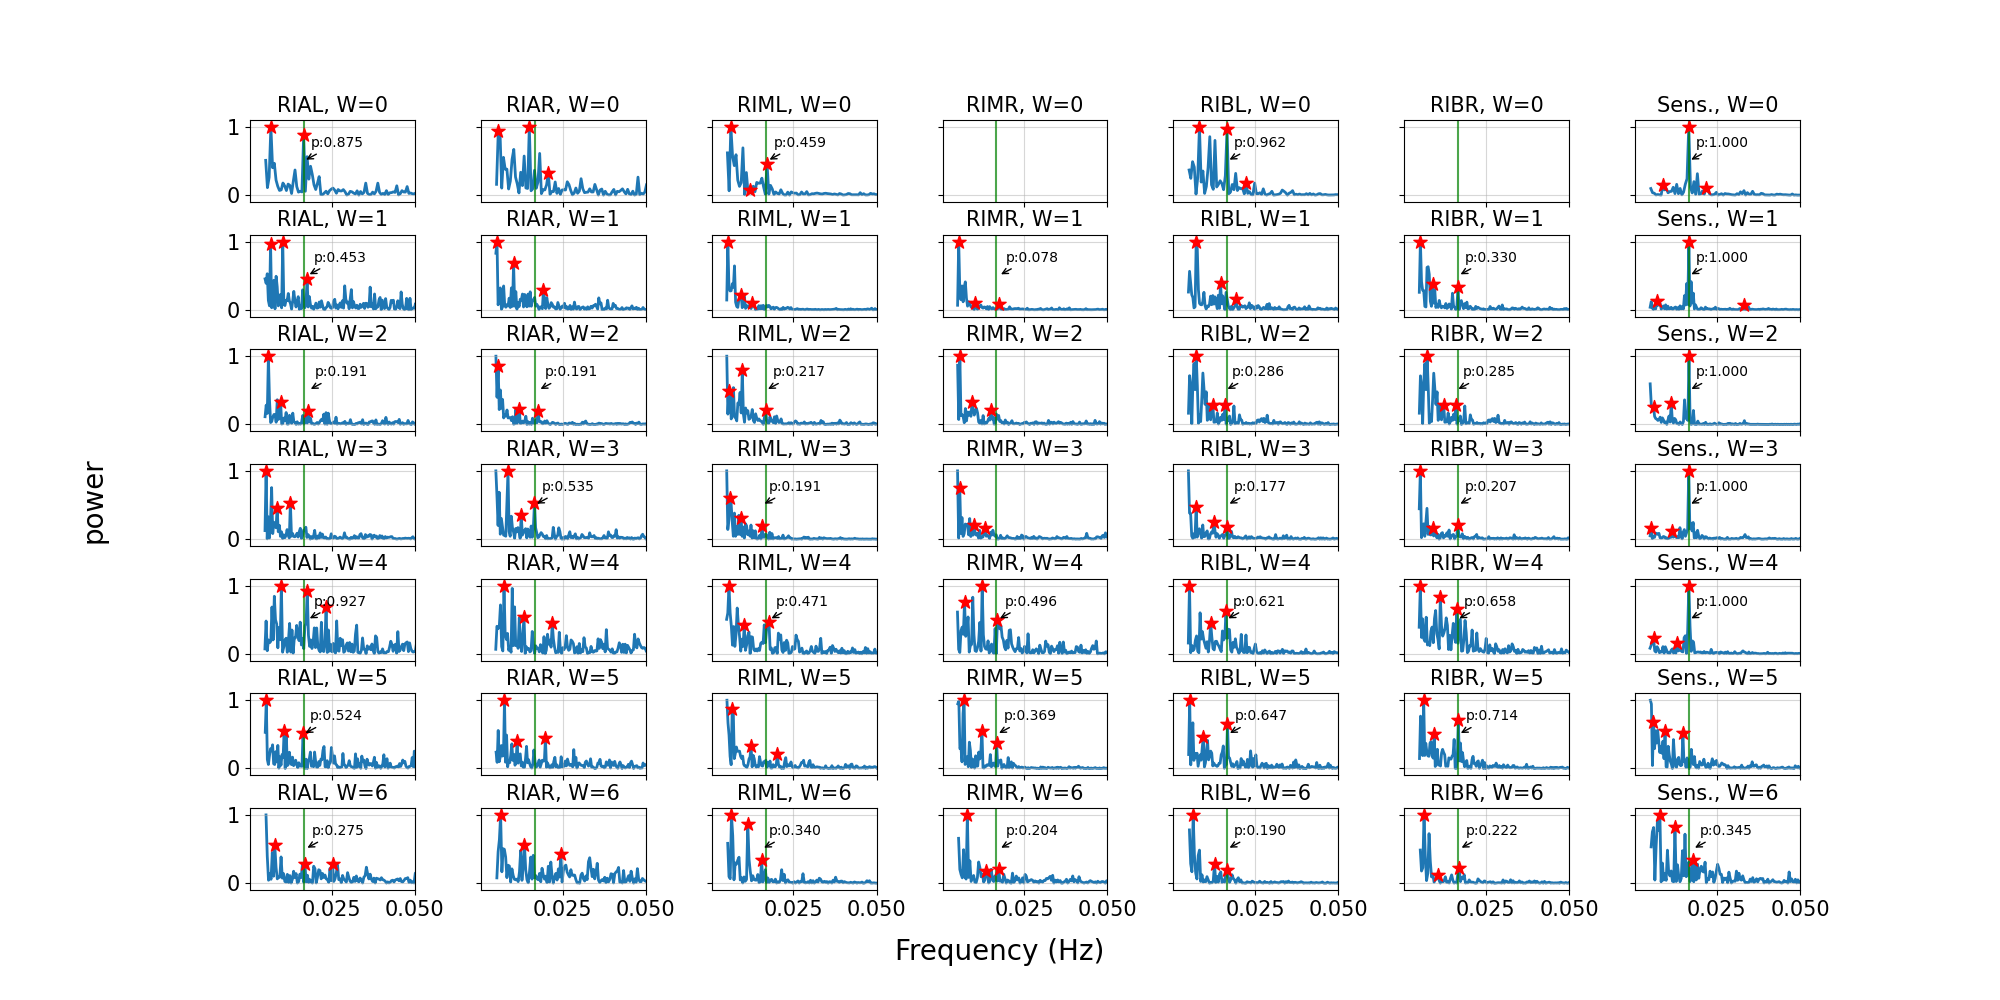

In [48]:

fig, axes = plt.subplots(7, 7, figsize=(20, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
Neur_lab = ["RIAL","RIAR","RIML","RIMR","RIBL","RIBR",'Sens.',"nrDL","loopL","nrDR","loopR","nrVL","nrVR"]
# Loop over all combinations of n and d
for n in range(7):
    for d in range(numW):
        ax = axes[d, n]  # Access the subplot
        
        # Extract data for current n and d
        neu = neu_ind[n]
        signal= AllF.compute_vector_z_score(MegaData_interp[d,:L[d],neu])
        sampling_interval = MegaData0[d,4,12] - MegaData0[d,3,12]
        a,b,p = fourier_andPlot(signal,sampling_interval,titre = Neur_lab[neu],ylab='Worm'+str(d),pl=False)
        

        ax.plot(b, a,lw=2,zorder=1)
        ax.axvline(0.016666,color='green',alpha=0.7)
        ax.scatter(b[p], a[p],marker = '*', color='red', label="Peaks",zorder=2,s=100)
        
        # Add titles and grid
        ax.set_title(Neur_lab[n]+f", W={d}", fontsize=15)
        ax.grid(alpha=0.5)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlim(right= 0.05)
        ax.grid(True)

        if len(p)>0:
            odor_peak = p[AllF.closest_index(b[p],0.01666666)]
            if np.abs(b[odor_peak]- 0.016666)<0.0015:
                ax.annotate(f"p:{a[odor_peak]:.3f}", (b[odor_peak],0.5), xytext=(5, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'))

        # Remove ticks for better readability
        ax.tick_params(axis='both', which='major', labelsize=15)

# Set shared labels
fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'power', va='center', rotation='vertical', fontsize=20)

### Plot Fourier spectrum for all neurites and sensory neuron for all worms.
Green line denotes the frequency of odor. The first 3 peaks of the spectrum are marked with red stars. If one of the first 3 peaks are close enough to odor frequency, its power is annotated by p in the plot

Text(0.04, 0.5, 'power')

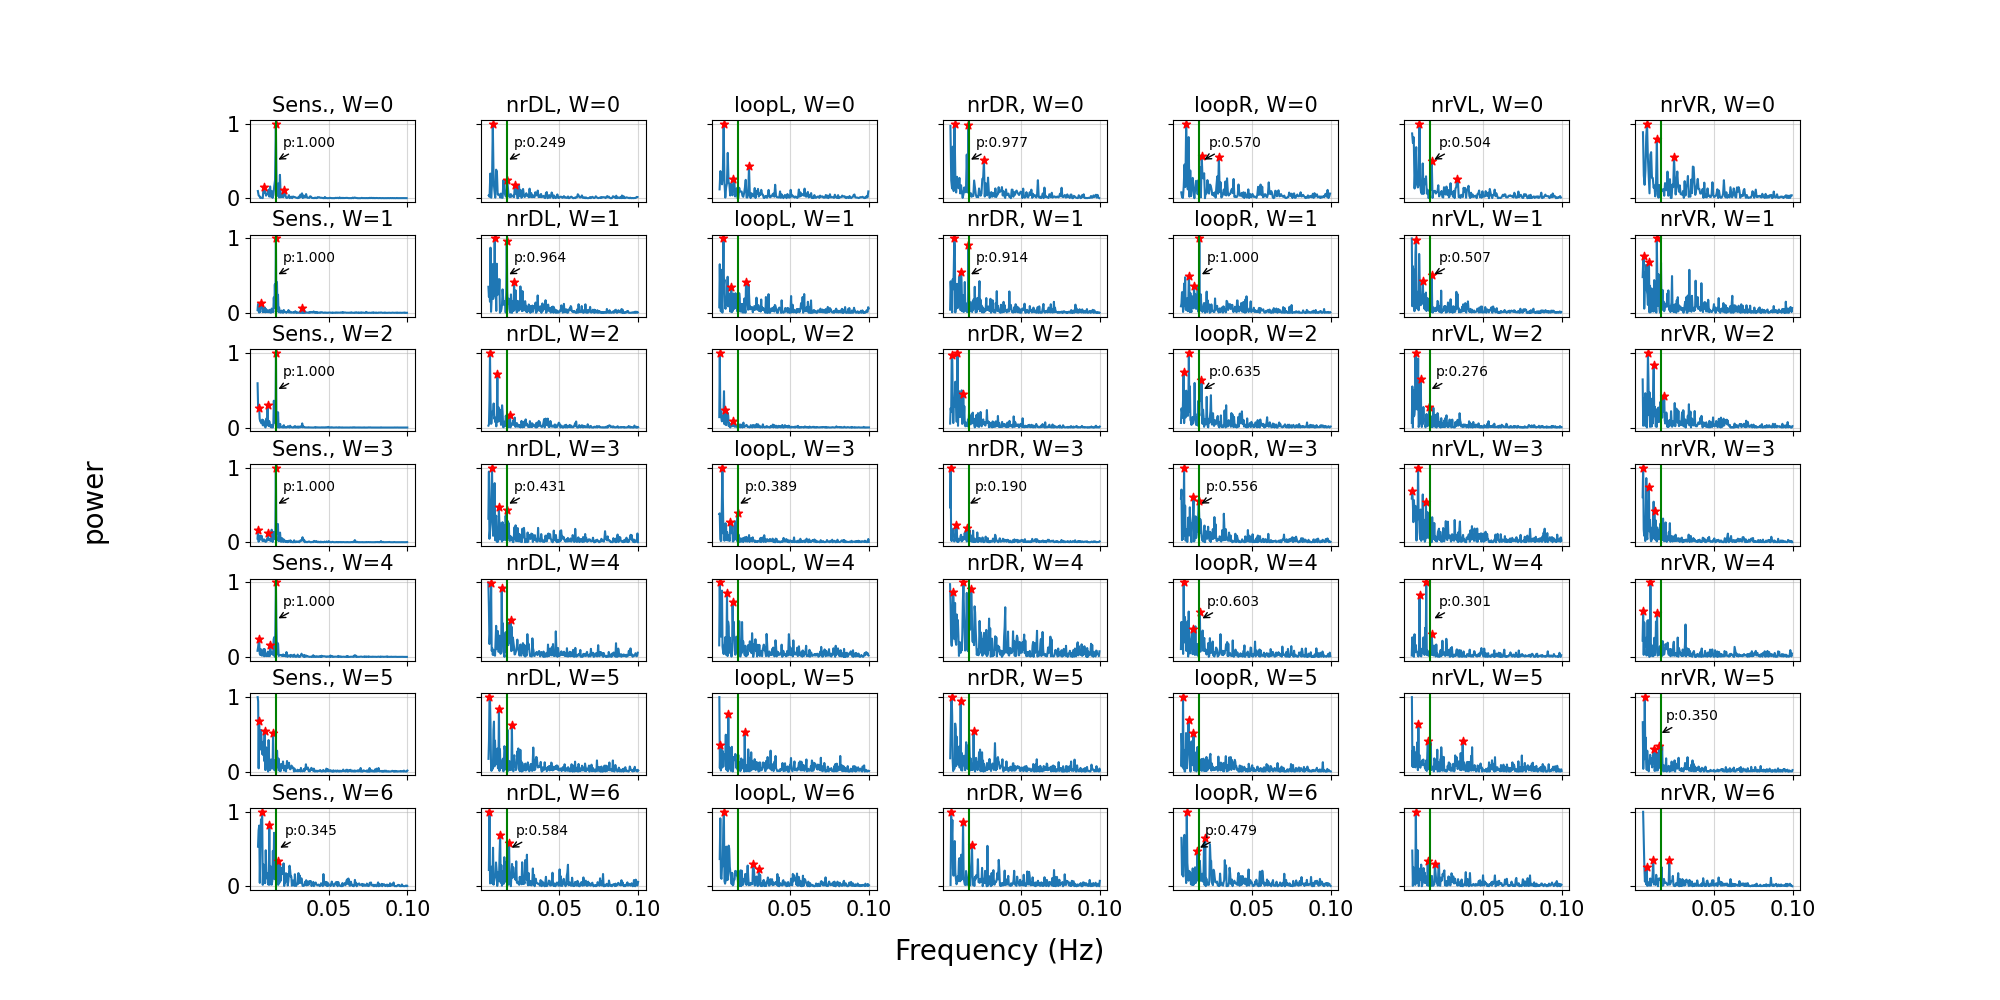

In [49]:

fig, axes = plt.subplots(7, 7, figsize=(20, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
Neur_lab = ["RIAL","RIAR","RIML","RIMR","RIBL","RIBR",'Sens.',"nrDL","loopL","nrDR","loopR","nrVL","nrVR"]
# Loop over all combinations of n and d
for n in range(7):
    for d in range(numW):
        ax = axes[d, n]
        
        # Extract data for current n and d
        neu = neu_ind[6+n]
        signal= AllF.compute_vector_z_score(MegaData_interp[d,:L[d],neu])
        sampling_interval = MegaData0[d,4,12] - MegaData0[d,3,12]
        a,b,p = fourier_andPlot(signal,sampling_interval,titre = 'neu'+str(neu),ylab='Worm'+str(d),pl=False)
        

        ax.plot(b, a)#,zorder=1)
        ax.scatter(b[p], a[p],marker = '*', color='red', label="Peaks",zorder=2)
        ax.axvline(0.016666,color='green')
        # Add titles and grid
        ax.set_title(Neur_lab[6+n]+f", W={d}", fontsize=15)
        ax.grid(alpha=0.5)
        if len(p)>0:
            odor_peak = p[AllF.closest_index(b[p],0.01666666)]
            if np.abs(b[odor_peak]- 0.016666)<0.0015:
                ax.annotate(f"p:{a[odor_peak]:.3f}", (b[odor_peak],0.5), xytext=(5, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'))

        # Remove ticks for better readability
        ax.tick_params(axis='both', which='major', labelsize=15)

# Set shared labels
fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'power', va='center', rotation='vertical', fontsize=20)